# Overview Figure 

Notebook for generating overview figure images

In [88]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [21]:
pth = '../../data/tcga/TCGA-LUAD-TPM-recount3-2023-02-21.tsv'
exp = pd.read_csv(pth, sep='\t', index_col=0)
exp = np.log2(exp + 1.0)
exp = exp[exp.mean(axis=1) > 1.0]
exp.index = [x.split(".")[0] for x in exp.index.values]

In [58]:
example_genes = exp.mean(axis=1).sort_values(ascending=False).index.values[np.linspace(0, len(exp) - 1, 5).astype(int) ]

In [59]:
example_exp = exp.reindex(example_genes).T

In [61]:
example_exp

,ENSG00000198804,ENSG00000116350,ENSG00000165501,ENSG00000179361,ENSG00000255641
5b1e3218-61b6-4d10-8815-c1038c739f05,13.550662,4.462296,3.728869,2.191770,2.512938
c3257122-09a9-449c-be4a-107703def60c,12.926778,4.160008,3.213276,1.761966,2.921040
6a4c997f-2f28-4888-8d4c-c2dc8b108520,13.204130,4.508462,3.059041,2.387427,1.198855
dc7450dc-4a7a-48ee-bef1-f5e5b46db020,14.900130,4.641449,3.034600,1.662850,1.759871
642c8ec2-4829-4b2b-af17-a6b52a793e26,14.695175,4.643616,2.804311,2.219958,0.229625
...,...,...,...,...,...
f59229d8-3570-4d7a-aed9-4ad6f128c6f9,14.491583,3.752606,3.086179,1.850962,1.141602
82f42146-d66d-488e-a7c8-bb338bf5d5fb,14.321297,5.237840,2.322450,2.458076,2.432030
ea8e7e8a-ef5b-4f87-b344-657b397aeefc,13.527271,4.582967,3.759059,2.893913,0.460449
8690fa0f-9c1c-4d97-813a-3fb56827fbfc,13.085255,5.256473,3.547332,2.124802,0.561228


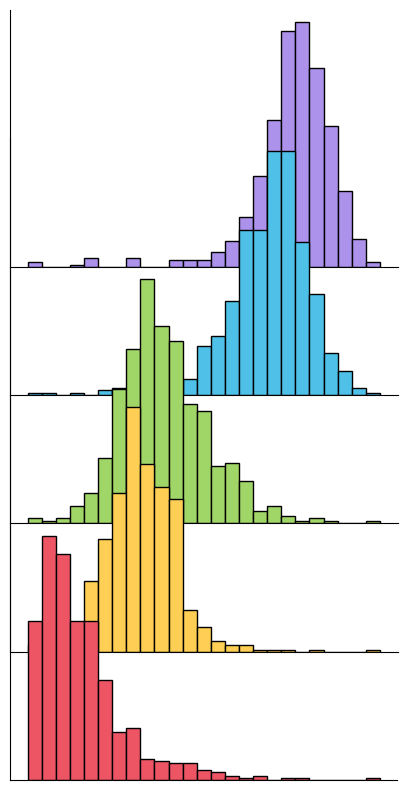

In [105]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(5, 10))

colors = ["#ac92eb", "#4fc1e8", "#a0d568", "#ffce54", "#ed5564"]
for i, gene in enumerate(example_exp.columns):
    
    sns.histplot(example_exp[gene].values, ax=axes[i], color=colors[i], alpha=1.0, bins=25)
    plt.setp(axes[i].lines, zorder=i)
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_ylabel("")
    axes[i].set_facecolor('none')
    
sns.despine()

plt.subplots_adjust(hspace=-0.5)

os.makedirs("../../figures/overview/", exist_ok=True)
plt.savefig("../../figures/overview/overlapping-histograms-log2tpm1.svg", 
            format='svg', 
            bbox_inches='tight',
            transparent=True)

In [91]:
from sklearn import preprocessing

tpm = (2**example_exp.T) - 1.0

scaler = preprocessing.MinMaxScaler(feature_range=(1, 100))
norm = pd.DataFrame(index=tpm.index, columns=example_exp.T.columns)

gene_bounds = pd.DataFrame(index=tpm.index, columns=['q1', 'q2', 'q3', 'upper_outlier', 'lower_outlier'])

for gene in norm.index.values:
    
    try:

        vec = tpm.loc[gene, :].values.reshape(-1, 1)
        q1 = np.percentile(vec, 25)
        q2 = np.percentile(vec, 50)
        q3 = np.percentile(vec, 75)

        upper_outlier = q3 + 1.5 * (q3 - q1)
        lower_outlier = q1 - 1.5 * (q3 - q1)

        gene_bounds.loc[gene, :] = [q1, q2, q3, upper_outlier, lower_outlier]

        idx, _ = np.where(vec > upper_outlier)
        vec[idx] = upper_outlier

        idx, _ = np.where(vec < lower_outlier)
        vec[idx] = lower_outlier

        norm.loc[gene, :] = scaler.fit_transform(vec).flatten()

    except Exception as e:
        print(e)

In [92]:
norm

,5b1e3218-61b6-4d10-8815-c1038c739f05,c3257122-09a9-449c-be4a-107703def60c,6a4c997f-2f28-4888-8d4c-c2dc8b108520,dc7450dc-4a7a-48ee-bef1-f5e5b46db020,642c8ec2-4829-4b2b-af17-a6b52a793e26,520354a4-9c4f-4cde-8e73-004e76d92a2e,d138ed54-1cd4-4fd6-b661-0087046f2730,cd5ae438-d578-472e-b7b2-1dbd52d43233,219a9b4a-c6eb-4d2a-aa44-fdb768ab3135,e1b8206b-c670-41f8-bfed-6d446f6b9737,...,e75d87af-dc22-4a00-8dac-ede1d242b3e5,3e400da6-7337-4af6-8ee7-e642de9f0ef0,cb00373b-2f05-44cb-898d-e12b30a4cef6,fb89a665-b6c3-41d8-91fe-6fbc8ad2ccf9,e820fd60-318f-4094-8d28-5305305508f9,f59229d8-3570-4d7a-aed9-4ad6f128c6f9,82f42146-d66d-488e-a7c8-bb338bf5d5fb,ea8e7e8a-ef5b-4f87-b344-657b397aeefc,8690fa0f-9c1c-4d97-813a-3fb56827fbfc,62c55da6-8041-42c4-bea8-62f24c4537fd
ENSG00000198804,35.999576,23.6425,28.483941,90.491717,78.613754,56.271016,54.00661,48.054085,52.057622,59.331413,...,86.027985,35.730382,38.092711,91.407282,26.627488,68.372628,60.849732,35.433507,26.294471,23.328467
ENSG00000116350,50.528583,40.221463,52.301588,57.737822,57.830615,34.90614,36.682111,49.693199,59.308242,62.535077,...,40.433872,78.572033,60.004968,44.070876,40.465343,29.342996,89.341398,55.285352,90.554704,36.343504
ENSG00000165501,68.682746,44.010209,38.186894,37.319914,29.833424,35.356524,16.423422,33.897704,54.166433,20.148731,...,43.489016,24.147121,33.49773,100.0,25.362704,39.166911,17.550719,70.419041,58.974731,100.0
ENSG00000179361,50.18596,33.351546,59.676524,30.130901,51.475184,38.881863,31.968615,26.730837,68.891561,28.119105,...,40.327564,42.608084,55.556541,16.65462,69.752794,36.438039,63.432281,91.149788,47.222211,47.90173
ENSG00000255641,100.0,100.0,41.951457,76.439909,6.453469,47.158856,37.916401,90.514237,18.731039,15.36253,...,62.052004,7.925225,14.341028,45.099135,7.44664,39.128347,100.0,12.883956,16.030726,6.394368


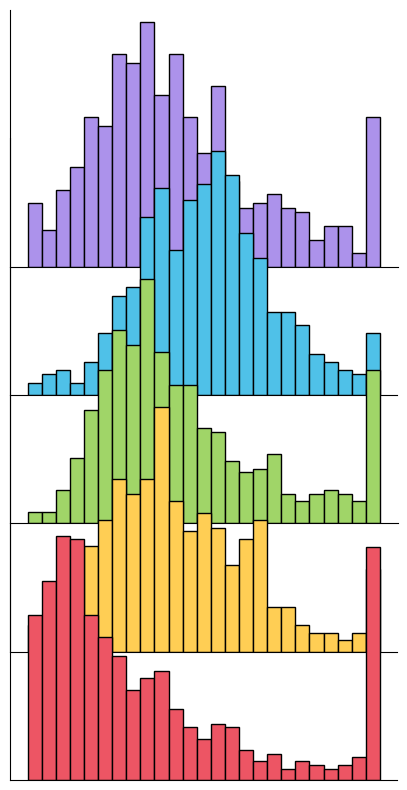

In [106]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(5, 10))

colors = ["#ac92eb", "#4fc1e8", "#a0d568", "#ffce54", "#ed5564"]
for i, gene in enumerate(norm.T.columns):
    
    sns.histplot(norm.T[gene].values, ax=axes[i], color=colors[i], alpha=1.0, bins=25)
    plt.setp(axes[i].lines, zorder=i)
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_ylabel("")
    axes[i].set_facecolor('none')
    
sns.despine()

plt.subplots_adjust(hspace=-0.5)

os.makedirs("../../figures/overview/", exist_ok=True)
plt.savefig("../../figures/overview/overlapping-histograms-normalized.svg", 
            format='svg', 
            bbox_inches='tight',
            transparent=True)

In [94]:
def roll_genes(genes):
    mgenes = np.empty((genes.shape[0], genes.shape[0]), dtype=object)
    for i in range(genes.shape[0]):
        for j, (g1, g2) in enumerate(zip(genes, np.roll(genes, i))):
            mgenes[j, i] = f"{g2}:{g1}"
    return mgenes
    
def divs(array):
    matrix = np.zeros((array.shape[0], array.shape[0]))
    for i in range(array.shape[0]):
        matrix[:, i] = np.roll(array, i)
    return matrix

def col_div(col):
    denominator = col
    numerator = divs(denominator)
    diffs = numerator / denominator[:, np.newaxis]
    return diffs.flatten()

def fast(mat):
    
    mgenes = roll_genes(np.arange(len(mat)))
    
    matrix = pd.DataFrame(index=mgenes.flatten(), 
                          columns=range(mat.shape[1]))
    
    for i in range(mat.shape[1]):
        matrix.loc[:, i] = col_div(mat[i].values)
            
    return matrix


ratio = fast(pd.DataFrame(norm.values))
ratio = ratio.astype(np.float64)
ratio.columns = tpm.columns

In [98]:
example_ratio = ratio.filter(regex="0:", axis=0)

In [100]:
example_ratio.T

,0:0,0:1,0:2,0:3,0:4
5b1e3218-61b6-4d10-8815-c1038c739f05,1.0,0.712460,0.524143,0.717324,0.359996
c3257122-09a9-449c-be4a-107703def60c,1.0,0.587808,0.537205,0.708888,0.236425
6a4c997f-2f28-4888-8d4c-c2dc8b108520,1.0,0.544609,0.745909,0.477306,0.678974
dc7450dc-4a7a-48ee-bef1-f5e5b46db020,1.0,1.567287,2.424757,3.003286,1.183828
642c8ec2-4829-4b2b-af17-a6b52a793e26,1.0,1.359380,2.635090,1.527217,12.181627
...,...,...,...,...,...
f59229d8-3570-4d7a-aed9-4ad6f128c6f9,1.0,2.330118,1.745673,1.876408,1.747394
82f42146-d66d-488e-a7c8-bb338bf5d5fb,1.0,0.681092,3.467079,0.959287,0.608497
ea8e7e8a-ef5b-4f87-b344-657b397aeefc,1.0,0.640920,0.503181,0.388739,2.750204
8690fa0f-9c1c-4d97-813a-3fb56827fbfc,1.0,0.290371,0.445860,0.556824,1.640255


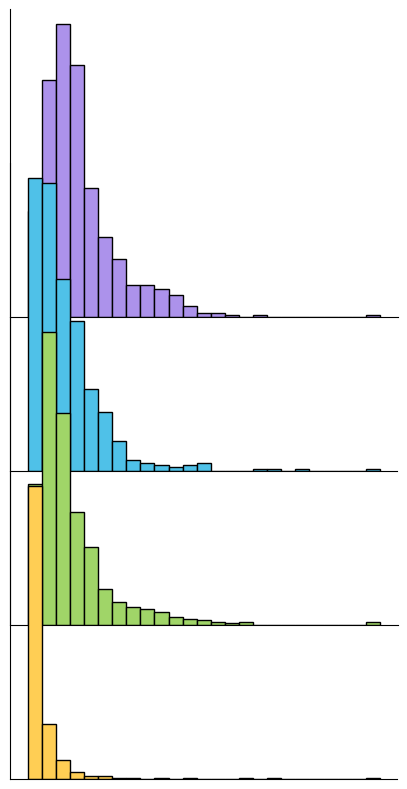

In [107]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(5, 10))

colors = ["#ac92eb", "#4fc1e8", "#a0d568", "#ffce54", "#ed5564"]
for i, gene in enumerate(example_ratio.T.columns[1:]):
    
    sns.histplot(example_ratio.T[gene].values, ax=axes[i], color=colors[i], alpha=1.0, bins=25)
    plt.setp(axes[i].lines, zorder=i)
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_ylabel("")
    axes[i].set_facecolor('none')
    
sns.despine()

plt.subplots_adjust(hspace=-0.5)

os.makedirs("../../figures/overview/", exist_ok=True)
plt.savefig("../../figures/overview/overlapping-histograms-ratios.svg", 
            format='svg', 
            bbox_inches='tight',
            transparent=True)